In [166]:
%reset -f

In [167]:
import anuga
import numpy as np
from hymo import SWMMInpFile
from pyswmm import Simulation, Nodes, Links
import matplotlib.pyplot as plt
import pandas as pd
from pyswmm import SystemStats
import matplotlib
from coupling_functions.coupling import calculate_Q, calculate_Q_v2
from coupling_functions.inlet_initialization import initialize_inlets
import datetime


### 
from anuga import Inlet_operator,Region


do_new_coupling   = True
manual_inlet_init = False
do_surf_rain      = True
expand_polygon    = True
zero_velocity     = True

visualise         = True
verbose           = False

time_average = 10 # sec
inlet_width  = 2.0
out_dt       = 2.0 # output step
n_sides      = 6

rf = 20  # refinement factor for domain, if too coarse the inlets will overlap the wall
# rf = 50  # refinement factor for domain, if too coarse the inlets will overlap the wall

# dt = 0.2     # yield step
ft = 600     # final timestep
cw = 0.6
co = 0.6
if do_surf_rain:
    outname =  'surf_swmm_input_long_culvert_3inlets'
else:
    outname =  'swmm_input_long_culvert_3inlets'

inp_name = outname + '.inp'
inp = SWMMInpFile(inp_name)

### Extract dt. Can either be datetime or decimal string
if any([letter  == ':' for letter in inp.options.loc['ROUTING_STEP'].Value]):
    dt = (datetime.datetime.strptime(inp.options.loc['ROUTING_STEP'].Value, "%H:%M:%S")- datetime.datetime(1900, 1, 1)).total_seconds()
else:
    dt = float(inp.options.loc['ROUTING_STEP'].Value)


plt.style.use('ggplot')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 10})

# baseline_flow  = inp.inflows.Baseline.values[0]

domain = anuga.rectangular_cross_domain(3*rf, rf, len1=60, len2=20,verbose = False)

domain.set_minimum_storable_height(0.0001) 
domain.set_name(outname)

def topography(x,y):
    z = 5*np.ones_like(x)
    channel = np.logical_and(y>5,y<15)
    z = np.where(channel, x/100, z)

    return z

domain.set_quantity('elevation', topography, location='centroids')
domain.set_quantity('friction', 0.035)

Br = anuga.Reflective_boundary(domain)
Bd = anuga.Dirichlet_boundary([-1.0,0,0])


sim = Simulation(inp_name)
sim.start()


## Giver måske ikke så meget mening at have her, men det andet bugger
baseline_flow  = 0
baseline_flows = []

for inflow in inp.inflows.Baseline.values:
    baseline_flow += inflow
    baseline_flows.append(inflow)


domain.set_boundary({'left': Bd, 'bottom': Bd, 'top': Bd, 'right': Bd})
if manual_inlet_init:
    inlet_polygon = [[50.0, 10-inlet_width/2], [52.0, 10-inlet_width/2], [52.0, 10+inlet_width/2], [50.0, 10+inlet_width/2]]
    inlet1_anuga_region = anuga.Region(domain, expand_polygon = expand_polygon, polygon=inlet_polygon)

    inlet2_polygon = [[40.0, 10-inlet_width/2], [42.0, 10-inlet_width/2], [42.0, 10+inlet_width/2], [40.0, 10+inlet_width/2]]
    inlet2_anuga_region = anuga.Region(domain, expand_polygon = expand_polygon, polygon=inlet2_polygon)

    inlet3_polygon = [[20.0, 10-inlet_width/2], [22.0, 10-inlet_width/2], [22.0, 10+inlet_width/2], [20.0, 10+inlet_width/2]]
    inlet3_anuga_region = anuga.Region(domain, expand_polygon = expand_polygon, polygon=inlet3_polygon)

    outlet_polygon = [[8.0, 10-inlet_width/2], [10.0, 10-inlet_width/2], [10.0, 10+inlet_width/2], [8.0, 10+inlet_width/2]]
    outlet_anuga_region = anuga.Region(domain, expand_polygon = expand_polygon, polygon=outlet_polygon)

    outfall_polygon = [[1.0, 10-inlet_width/2], [2.0, 10-inlet_width/2], [2.0, 10+inlet_width/2], [1.0, 10+inlet_width/2]]
    outfall_anuga_region = anuga.Region(domain, expand_polygon = expand_polygon, polygon=outfall_polygon)

    # inlet1_anuga_inlet_op = Inlet_operator(domain, inlet1_anuga_region, Q=0.0, zero_velocity=zero_velocity)
    # inlet2_anuga_inlet_op = Inlet_operator(domain, inlet2_anuga_region, Q=0.0, zero_velocity=zero_velocity)
    # inlet3_anuga_inlet_op = Inlet_operator(domain, inlet3_anuga_region, Q=0.0, zero_velocity=zero_velocity)
    # outlet_anuga_inlet_op = Inlet_operator(domain, outlet_anuga_region, Q=0.0, zero_velocity=zero_velocity)

    # if do_surf_rain:
    #     baseline_flow = 0.5
    #     rain_operators   = Inlet_operator(domain, inlet1_anuga_region, Q = baseline_flow, zero_velocity=zero_velocity)
    # else:
    #     rain_operators   = Inlet_operator(domain, inlet1_anuga_region, Q = 0.0, zero_velocity=zero_velocity)

    inlet1_anuga_inlet_op = anuga.Inlet_operator(domain, inlet1_anuga_region, Q=0.0, zero_velocity=zero_velocity)
    inlet2_anuga_inlet_op = anuga.Inlet_operator(domain, inlet2_anuga_region, Q=0.0, zero_velocity=zero_velocity)
    inlet3_anuga_inlet_op = anuga.Inlet_operator(domain, inlet3_anuga_region, Q=0.0, zero_velocity=zero_velocity)
    outlet_anuga_inlet_op = anuga.Inlet_operator(domain, outlet_anuga_region, Q=0.0, zero_velocity=zero_velocity)

    if do_surf_rain:
        baseline_flow = 0.5
        rain_operators   = anuga.Inlet_operator(domain, inlet1_anuga_region, Q = baseline_flow, zero_velocity=zero_velocity)
    else:
        rain_operators   = anuga.Inlet_operator(domain, inlet1_anuga_region, Q = 0.0, zero_velocity=zero_velocity)


    inlet_elevation = np.array([inlet1_anuga_inlet_op.inlet.get_average_elevation(),
                        inlet2_anuga_inlet_op.inlet.get_average_elevation(),
                        inlet3_anuga_inlet_op.inlet.get_average_elevation(),
                        outlet_anuga_inlet_op.inlet.get_average_elevation()])
    swmm_inlet1 = Nodes(sim)['Inlet1']
    swmm_inlet2 = Nodes(sim)['Inlet2']
    swmm_inlet3 = Nodes(sim)['Inlet3']
    swmm_outlet = Nodes(sim)['Outlet']
    swmm_outfall = Nodes(sim)['Outfall']

    swmm_culvert1 = Links(sim)['Conduit1']
    swmm_culvert2 = Links(sim)['Conduit2']
    swmm_culvert3 = Links(sim)['Conduit3']
    swmm_outpipe = Links(sim)['Outpipe']
    link_volume_0 = swmm_culvert1.volume + swmm_culvert2.volume +swmm_culvert3.volume + swmm_outpipe.volume

else: # ~manual_inlet_init       
    inlet_operators,inlet_elevation,_,inlet_vertices = initialize_inlets(domain,sim,inp,n_sides,
                                                                        len(baseline_flows)*[2*inlet_width], len(baseline_flows)*[0.0],
                                                                        rotation = -np.pi/4, zero_velocity = zero_velocity, expand_polygon = expand_polygon)

    if do_surf_rain:
        baseline_flows = [0.5, 0.0, 0.0, 0.0]
        baseline_flow = 0.5
        rain_operators,inlet_elevation,_,_ = initialize_inlets(domain, sim, inp, n_sides, len(baseline_flows)*[2*inlet_width], baseline_flows, zero_velocity = zero_velocity, expand_polygon = expand_polygon)
    else:
        rain_operators,_,_,_ = initialize_inlets(domain, sim, inp, n_sides, len(baseline_flows)*[2*inlet_width], len(baseline_flows)*[0.0], zero_velocity = zero_velocity, expand_polygon = expand_polygon)

    link_volume_0 = sum(link.volume for link in Links(sim))
        
inlet_weir_lengths = np.array(4 * [2*inlet_width])
anuga_area_manholes = np.array(4 * [2*inlet_width])


zero_velocity: True
expand_polygon: True

 o  Retrieving project datazero_velocity: True
expand_polygon: True


/home/anton/miniforge3/envs/anuga_env/lib/python3.8/site-packages/anuga/structures/riverwall.py:124: RuntimeWarning: invalid value encountered in cast
  self.hydraulic_properties_rowIndex=numpy.array([default_int]).astype(int)


Plot inlets below:

In [173]:
def node_link_connectivity(sim):
    link2node = dict()
    node2link = {node.nodeid: [] for node in Nodes(sim)}
    for link in Links(sim):
        link2node[link.linkid] = link.connections
        for nodeid in link.connections:
            node2link[nodeid].append(link.linkid)
    return link2node, node2link

link2node,node2link = node_link_connectivity(sim)


flow_rates = []
link1_flows = []
link2_flows = []
node2_inflows = []
node2_outflows = []
# Nodes(sim)['Inlet1'].generated_inflow(2)
node = Nodes(sim)['Inlet2']
node.generated_inflow = -10  # apply a negative inflow of 10 m3/s
for step in sim:
    link_flow_rates = []
    node2_inflows.append(node.total_inflow)
    node2_outflows.append(node.total_outflow)
    for link_name in node2link['Inlet2']:
        link_flow = Links(sim)[link_name].flow
        link_flow_rates.append(link_flow)
        if link_name == 'Conduit1':
            link1_flows.append(link_flow)
        else:
            link2_flows.append(link_flow)
    
    # calculate the total flow out of the node
    # total_outflow = sum(link_flow_rates)
    total_outflow = link_flow_rates[1] - link_flow_rates[0]
    
    # calculate the flow rate corresponding to the amount of water removed from the pipes
    flow_rate = min(-node.generated_inflow, total_outflow)
    flow_rates.append(flow_rate)
    # print(f'Current flow rate: {flow_rate}')


plt.plot(link1_flows,label = 'link1')
plt.plot(link2_flows,label = 'link2')
plt.legend()
plt.figure()
plt.plot(np.array(link1_flows) - np.array(link2_flows))

plt.figure()
plt.plot(node2_inflows,label = 'in')
plt.plot(node2_outflows,label = 'out')
plt.legend()

plt.figure()
plt.plot(np.array(node2_inflows) - np.array(link1_flows),label = 'in-link1')

plt.plot(np.array(node2_outflows) - np.array(link2_flows),label = 'out-link2')
plt.legend()


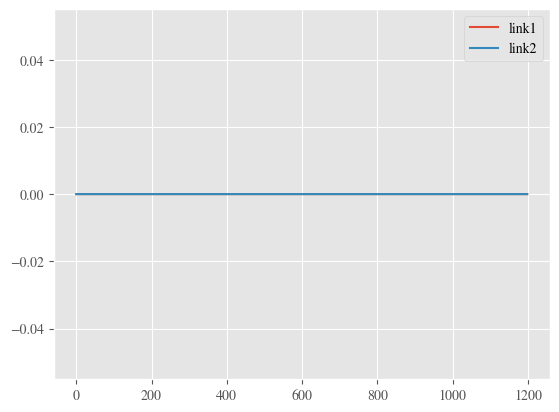

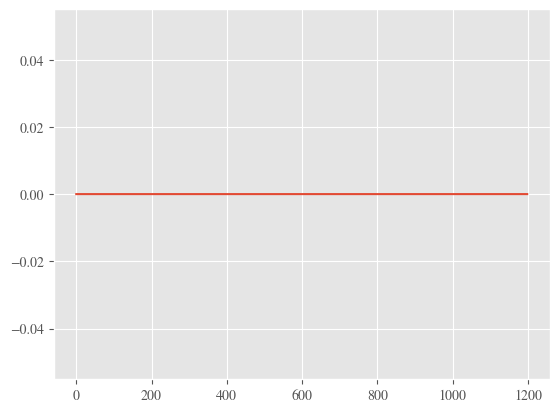

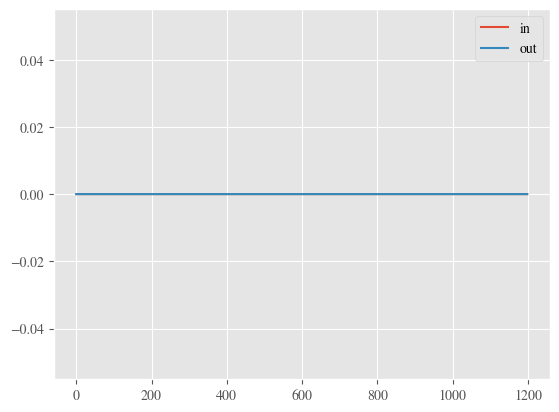

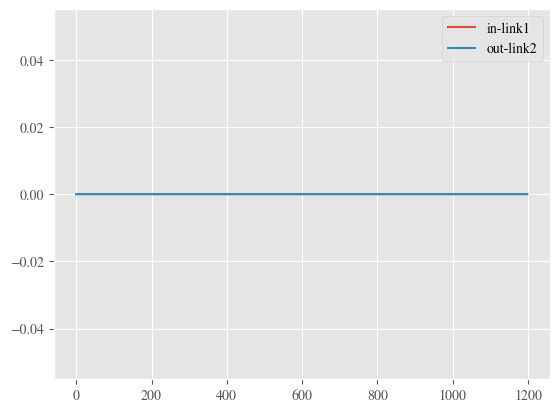

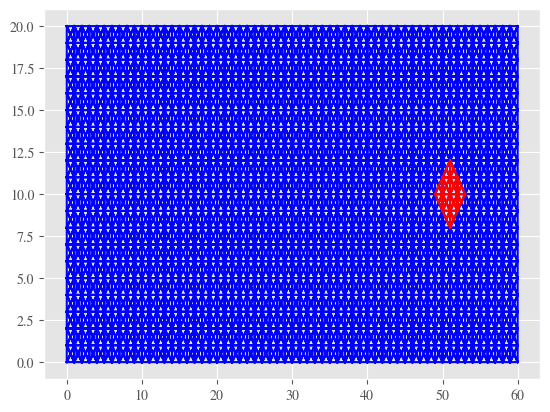

In [ ]:
# if manual_inlet_init:
#     inlet1_anuga_inlet_op.inlet.region.plot_region_v2()
# else:
#     inlet_operators['Inlet2'].inlet.region.plot_region_v2()
if manual_inlet_init:
    inlet1_anuga_inlet_op.inlet.region.plot_region()
else:
    inlet_operators['Inlet1'].inlet.region.plot_region()

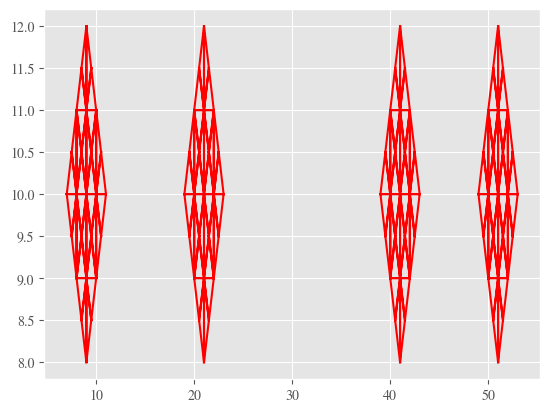

In [ ]:
if manual_inlet_init:
    inlet1_anuga_inlet_op.inlet.region.plot_region_v2()
    inlet2_anuga_inlet_op.inlet.region.plot_region_v2()
    inlet3_anuga_inlet_op.inlet.region.plot_region_v2()
    outlet_anuga_inlet_op.inlet.region.plot_region_v2()

else:
    for node in Nodes(sim):
        if node.is_junction():
            inlet_operators[node.nodeid].inlet.region.plot_region_v2()


In [ ]:
system_routing = SystemStats(sim)
conduit_volume_list= []
conduit_depth_list = []
inlet_vol_list     = []
inlet1_flood_flows = []
outlet_flood_flows = []
outlet_lateral_vol = []
inlet_lateral_vol  = []
outlet_flood_vol   = []
inlet_flood_vol    = []
node_head_list     = []
external_flows     = []
domain_volumes     = []
outfall_flows      = []
sewer_volumes      = []
correct_vols       = []
outlet_flows       = []
inlet_flows        = []
time_series        = []
Q_in_cumus         = []
real_vols          = []
anuga_ws           = []
losses             = []
Q_ins              = []
H_js               = []
Q_in_old = np.array([0.0, 0.0, 0.0, 0.0])

old_inlet_vol = len(baseline_flows)*[0.0]

cumulative_inlet_flooding  = 0.0
cumulative_outlet_flooding = 0.0
cumulative_inlet_flow      = 0.0
cumulative_outlet_flow     = 0.0
cumulative_outfall_vol    = 0.0
Q_in_cumu = 0
old_outlet_vol = 0.0
old_inlet1_vol = 0.0
old_inlet2_vol = 0.0
old_inlet3_vol = 0.0
old_inlet1_flood   = 0
old_inlet2_flood   = 0
old_inlet3_flood   = 0
old_outlet_flood   = 0
link_volume = link_volume_0
in_node_ids = [node.nodeid for node in Nodes(sim) if node.is_junction()]

inlet_cell_vols = []
inlet_cell_vols2 = []
anuga_depths_list = []
anuga_depths_list2 = []
node_heads_list = []
node_heads_list2 = []

In [ ]:
domain.output_frequency = 100
for t in domain.evolve(yieldstep=dt, outputstep=out_dt, finaltime=ft):
    node_volume = 0.0
    sewer_volume = link_volume + node_volume

    boundary_flux        = domain.get_boundary_flux_integral()
    domain_volume        = domain.get_water_volume()
    total_volume_correct = baseline_flow * t + 0.5*baseline_flow + boundary_flux  + link_volume_0 - cumulative_outfall_vol
    total_volume_real    = domain_volume + sewer_volume
    loss                 = total_volume_real - total_volume_correct

    conduit_volume_list.append([link.volume for link in Links(sim)])
    conduit_depth_list.append([link.depth for link in Links(sim)])
    external_flows.append(system_routing.routing_stats['external_inflow'])
    correct_vols.append(total_volume_correct)
    real_vols.append(total_volume_real)
    domain_volumes.append(domain_volume)
    sewer_volumes.append(sewer_volume)
    time_series.append(t)
    losses.append(loss)

    if manual_inlet_init:
        anuga_depths = np.array([inlet1_anuga_inlet_op.inlet.get_average_depth(),
                                inlet2_anuga_inlet_op.inlet.get_average_depth(),
                                inlet3_anuga_inlet_op.inlet.get_average_depth(),
                                outlet_anuga_inlet_op.inlet.get_average_depth()])
        link_volume = swmm_culvert1.volume + swmm_culvert2.volume +swmm_culvert3.volume + swmm_outpipe.volume
        inlet1_head  = swmm_inlet1.head
        inlet2_head  = swmm_inlet2.head
        inlet3_head  = swmm_inlet3.head
        outlet_head  = swmm_outlet.head
        outfall_head = swmm_outfall.head
        node_heads   = np.array([inlet1_head, inlet2_head, inlet3_head, outlet_head])
        inlet_volumes = [inlet1_anuga_inlet_op.inlet.get_total_water_volume(),inlet2_anuga_inlet_op.inlet.get_total_water_volume(),inlet3_anuga_inlet_op.inlet.get_total_water_volume(), outlet_anuga_inlet_op.inlet.get_total_water_volume()]
        cumulative_inlet_flooding += swmm_inlet1.flooding*dt 
        cumulative_outlet_flooding += swmm_outlet.flooding*dt

    else: # ~manual_inlet_init
        anuga_depths = np.array([inlet_operators[node.nodeid].inlet.get_average_depth() for node in Nodes(sim) if node.is_junction()])
        link_volume = sum([link.volume for link in Links(sim)])
        node_heads    = np.array([node.head for node in Nodes(sim) if node.is_junction()])
        inlet_volumes = [inlet_operators[node.nodeid].inlet.get_total_water_volume() for node in Nodes(sim) if node.is_junction()]

    if do_new_coupling:
        Q_in     = 1.0*calculate_Q_v2(node_heads, anuga_depths, inlet_elevation, inlet_weir_lengths, anuga_area_manholes, inlet_volumes = inlet_volumes, dt = dt, cw = cw, co = co)
    else:
        Q_in     = calculate_Q(node_heads, anuga_depths, inlet_elevation, inlet_weir_lengths, anuga_area_manholes, cw = cw, co = co)

    Q_in     = ((time_average - dt)*Q_in_old + dt*Q_in)/time_average
    Q_in_old = Q_in
    Q_ins.append(Q_in.copy())
    Q_in_cumu += sum(Q_in)
    Q_in_cumus.append(Q_in_cumu)

    if manual_inlet_init:
        swmm_inlet1.generated_inflow(Q_in[0])
        swmm_inlet2.generated_inflow(Q_in[1])
        swmm_inlet3.generated_inflow(Q_in[2])
        swmm_outlet.generated_inflow(Q_in[3])
    else: # ~manual_inlet_init
        for nodeid, Qin in zip(in_node_ids, Q_in):
            Nodes(sim)[nodeid].generated_inflow(Qin)    

    sim.step_advance(dt)
    sim.next()

    if manual_inlet_init:
        inlet1_vol = - swmm_inlet1.statistics['lateral_infow_vol'] + swmm_inlet1.statistics['flooding_volume']
        inlet1_flow = (inlet1_vol - old_inlet1_vol)/dt
        old_inlet1_vol = inlet1_vol
        inlet2_vol = - swmm_inlet2.statistics['lateral_infow_vol'] + swmm_inlet2.statistics['flooding_volume'] 
        inlet2_flow = (inlet2_vol - old_inlet2_vol)/dt
        old_inlet2_vol = inlet2_vol
        inlet3_vol = - swmm_inlet3.statistics['lateral_infow_vol'] + swmm_inlet3.statistics['flooding_volume'] 
        inlet3_flow = (inlet3_vol - old_inlet3_vol)/dt
        old_inlet3_vol = inlet3_vol
        outlet_vol = - swmm_outlet.statistics['lateral_infow_vol'] + swmm_outlet.statistics['flooding_volume'] 
        outlet_flow = (outlet_vol - old_outlet_vol)/dt
        old_outlet_vol = outlet_vol

        inlet_flows.append(inlet1_flow)
        outlet_flows.append(outlet_flow)

        cumulative_inlet_flow += inlet1_flow*dt
        cumulative_outlet_flow += outlet_flow*dt

        if do_surf_rain:
            inlet1_anuga_inlet_op.set_Q(inlet1_flow)
        else: # ~surf_rain
            inlet1_anuga_inlet_op.set_Q(inlet1_flow + baseline_flow)

        inlet2_anuga_inlet_op.set_Q(inlet2_flow)
        inlet3_anuga_inlet_op.set_Q(inlet3_flow)
        # outlet_anuga_inlet_op.set_Q(outlet_flow + swmm_outfall.total_inflow)
        outlet_anuga_inlet_op.set_Q(outlet_flow)


    else: # ~manual_inlet_init
        inlet_vol       = [- node.statistics['lateral_infow_vol'] + node.statistics['flooding_volume'] for node in Nodes(sim) if node.is_junction()]
        inlet_flow      = [(new_vol - old_vol)/dt for new_vol, old_vol in zip(inlet_vol,old_inlet_vol)]
        old_inlet_vol   = inlet_vol.copy()

        inlet_idx = 0

        if do_surf_rain:
            for node in Nodes(sim):
                if node.is_junction():
                    inlet_operators[node.nodeid].set_Q(inlet_flow[inlet_idx])
                    inlet_idx += 1
        else: # ~surf_rain
            for node in Nodes(sim):
                if node.is_junction():
                    inlet_operators[node.nodeid].set_Q(inlet_flow[inlet_idx] + baseline_flows[inlet_idx])
                    inlet_idx += 1

    cumulative_outfall_vol += Nodes(sim)['Outfall'].total_inflow*dt
    outfall_flows.append(Nodes(sim)['Outfall'].total_inflow)
    inlet_vol_list.append(inlet_vol)
    print_out = domain.yieldstep_counter%domain.output_frequency == 0
    if print_out:
        domain.print_timestepping_statistics()
        print(inlet_volumes)


# sim.close()


Time = 0.0000 (sec), steps=0 (1s)
[0.0, 0.0, 0.0, 0.0]
Time = 100.0000 (sec), delta t in [0.08921996, 0.09221162] (s), steps=12 (3s)
[0.0864121975201051, 0.3360697150548613, 0.9496176165921152, 1.142651339468976]
Time = 200.0000 (sec), delta t in [0.09077813, 0.09164031] (s), steps=11 (3s)
[0.0596434638635355, 0.30284369809172684, 0.6911808776327109, 0.6195553428564822]
Time = 300.0000 (sec), delta t in [0.08882511, 0.09023937] (s), steps=12 (2s)
[0.0433984635188959, 0.5552018286286071, 0.7876508017039858, 1.3072707556101133]
Time = 400.0000 (sec), delta t in [0.08261529, 0.08499264] (s), steps=12 (2s)
[0.10201963249203796, 0.28408793795020826, 0.9542935182742455, 1.0006946906739183]
Time = 500.0000 (sec), delta t in [0.09079813, 0.09276949] (s), steps=11 (3s)
[0.0911865360323953, 0.48527066565704535, 0.6704108344638391, 0.7013856663736566]
Time = 600.0000 (sec), delta t in [0.08563632, 0.08811272] (s), steps=12 (3s)
[0.08740915065516416, 0.30092009894656213, 1.0029593361281421, 0.8602

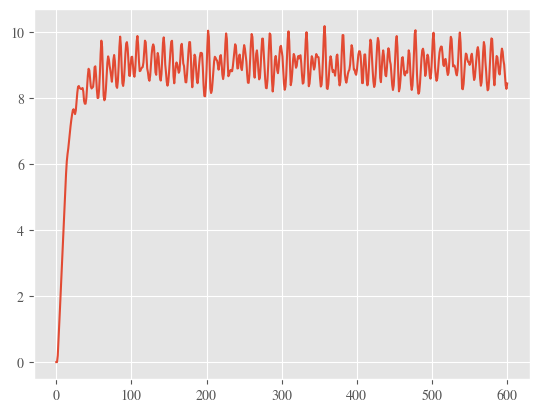

In [ ]:
plt.plot(sewer_volumes)

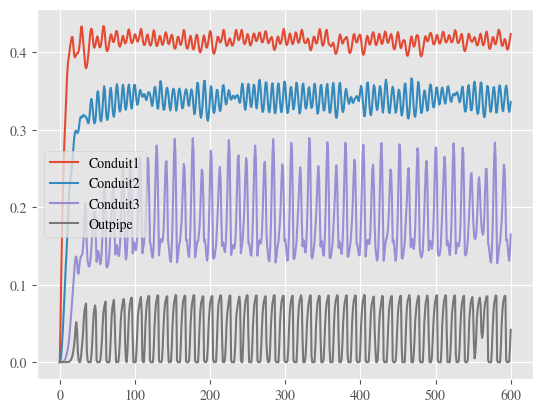

In [ ]:
plt.plot(conduit_depth_list, label = [link.linkid for link in Links(sim)])
plt.legend()

In [ ]:
for node in Nodes(sim):
    print(node.nodeid)

Inlet1
Inlet2
Inlet3
Outlet
Outfall


In [ ]:
sim.get_node('Inlet1')


NameError: name 'sim' is not defined

In [ ]:
sim.get_node('Inlet1')
for node in Nodes(sim):
    print(node.outlinks)

In [ ]:
inlet_elevation

array([0.51, 0.41, 0.21, 0.09])

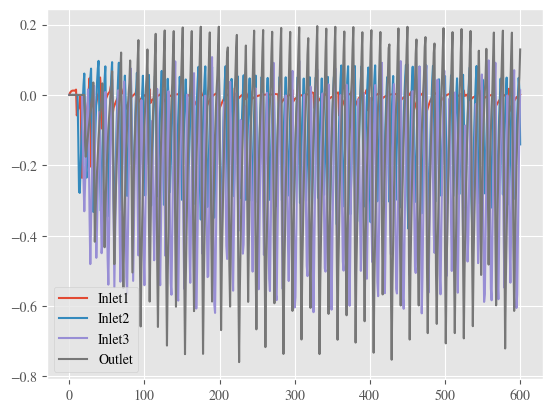

In [ ]:
plt.plot(np.array(Q_ins)*dt, label = in_node_ids)
# plt.plot(np.array(inlet_cell_vols),'.', label = in_node_ids)
plt.legend()

In [ ]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

date and time = 30/03/2023 08:22:12


In [ ]:
print(f'cw,co: {cw}, {co}')
print(f'Inlet width: {inlet_width}')
print(f'Do new coupling: {do_new_coupling}')
print(20*'#')
print(f'Manual inlet initialization: {manual_inlet_init}')
print(f'Rain on surface: {do_surf_rain}')
print(f'Expand polygon: {expand_polygon}')
print(f'Zero velocity: {zero_velocity}')


cw,co: 0.6, 0.6
Inlet width: 2.0
Do new coupling: True
####################
Manual inlet initialization: False
Rain on surface: False
Expand polygon: True
Zero velocity: True


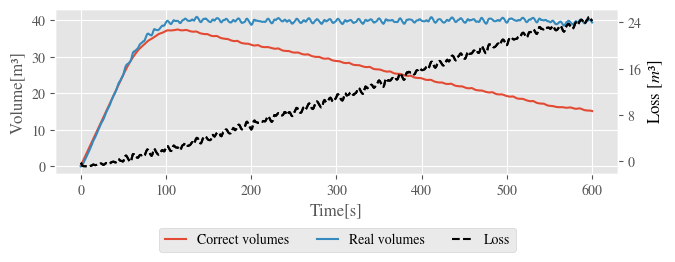

In [ ]:
inch = 2.54
fig_size = 17

fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)

ax.plot(time_series,correct_vols,label = 'Correct volumes')
ax.plot(time_series,real_vols, label = 'Real volumes')
ax.set_xlabel('Time[s]')
ax.set_ylabel('Volume[m³]')

diff_ax = ax.twinx()
diff_ax.plot(time_series,losses,label = 'Loss',color = 'k',linestyle = '--')
diff_ax.plot(time_series,np.array(real_vols)- np.array(correct_vols),label = 'Loss',color = 'k',linestyle = '--')

diff_ax.grid(False)
diff_ax.set_ylabel('Loss [$m³$]')
diff_ax.yaxis.set_major_locator(plt.MaxNLocator(4))

diff_ax.yaxis.label.set_color(diff_ax.get_lines()[0].get_color())
ax.plot([],[],color = 'k',linestyle = '--',label = 'Loss')


fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15),handlelength=1.5,ncol=5)
if False:
    # plt.savefig(plot_path +'vol_vs_method_' + plotname + '.eps',format = 'eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
    if do_surf_rain:

        if do_new_coupling:
            plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_surf' + '_new_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.eps', bbox_inches='tight')
            plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_surf' + '_new_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.png', bbox_inches='tight')

        else: 
            plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_surf' + '_old_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.eps', bbox_inches='tight')
            plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_surf' + '_old_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.png', bbox_inches='tight')
    else:

        if do_new_coupling:
            plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_pipe' + '_new_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.eps', bbox_inches='tight')
            plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_pipe' + '_new_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.png', bbox_inches='tight')

        else: 
            plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_pipe' + '_old_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.eps', bbox_inches='tight')
            plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_pipe' + '_old_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.png', bbox_inches='tight')


In [ ]:
dt

1.0

In [ ]:
real_vols[-1]

39.380165092573414

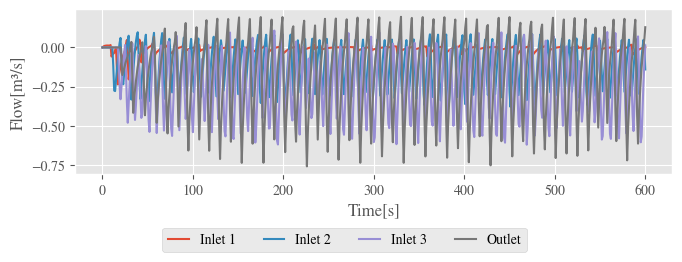

In [ ]:

inch = 2.54
fig_size = 17
# fig_size = 34

fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)

ax.plot(Q_ins,label = ['Inlet 1' , 'Inlet 2', 'Inlet 3', 'Outlet'])
ax.set_xlabel('Time[s]')
ax.set_ylabel('Flow[m³/s]')
fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15),handlelength=1.5,ncol=5)